In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD


In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [3]:
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

In [4]:
all_lines = input_texts + target_texts

In [5]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [6]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [7]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [8]:
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [9]:
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM), encoding="utf8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [10]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [11]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [12]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)


In [13]:
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

In [21]:
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 1s 680us/sample - loss: 3.9873 - accuracy: 0.0836 - val_loss: 4.8324 - val_accuracy: 0.0813
Epoch 2/2000
1148/1148 [==============================] - 1s 628us/sample - loss: 3.9508 - accuracy: 0.0904 - val_loss: 4.8387 - val_accuracy: 0.0839
Epoch 3/2000
1148/1148 [==============================] - 1s 630us/sample - loss: 3.9155 - accuracy: 0.0956 - val_loss: 4.8487 - val_accuracy: 0.0865
Epoch 4/2000
1148/1148 [==============================] - 1s 642us/sample - loss: 3.8828 - accuracy: 0.0975 - val_loss: 4.8572 - val_accuracy: 0.0862
Epoch 5/2000
1148/1148 [==============================] - 1s 848us/sample - loss: 3.8502 - accuracy: 0.0989 - val_loss: 4.8639 - val_accuracy: 0.0862
Epoch 6/2000
1148/1148 [==============================] - 1s 642us/sample - loss: 3.8158 - accuracy: 0.1004 - val_loss: 4.8696 - val_accuracy: 0.0871
Epoch 7/2000
1148/1148 [=============================

1148/1148 [==============================] - 1s 605us/sample - loss: 2.4653 - accuracy: 0.2342 - val_loss: 5.1968 - val_accuracy: 0.0935
Epoch 56/2000
1148/1148 [==============================] - 1s 591us/sample - loss: 2.4486 - accuracy: 0.2377 - val_loss: 5.2104 - val_accuracy: 0.0932
Epoch 57/2000
1148/1148 [==============================] - 1s 606us/sample - loss: 2.4320 - accuracy: 0.2376 - val_loss: 5.2211 - val_accuracy: 0.0923
Epoch 58/2000
1148/1148 [==============================] - 1s 636us/sample - loss: 2.4147 - accuracy: 0.2417 - val_loss: 5.2300 - val_accuracy: 0.0926
Epoch 59/2000
1148/1148 [==============================] - 1s 654us/sample - loss: 2.3995 - accuracy: 0.2418 - val_loss: 5.2409 - val_accuracy: 0.0914
Epoch 60/2000
1148/1148 [==============================] - 1s 597us/sample - loss: 2.3828 - accuracy: 0.2434 - val_loss: 5.2432 - val_accuracy: 0.0923
Epoch 61/2000
1148/1148 [==============================] - 1s 608us/sample - loss: 2.3681 - accuracy: 0.2449

1148/1148 [==============================] - 1s 601us/sample - loss: 1.8682 - accuracy: 0.3161 - val_loss: 5.6752 - val_accuracy: 0.0836
Epoch 110/2000
1148/1148 [==============================] - 1s 648us/sample - loss: 1.8607 - accuracy: 0.3182 - val_loss: 5.6759 - val_accuracy: 0.0856
Epoch 111/2000
1148/1148 [==============================] - 1s 666us/sample - loss: 1.8540 - accuracy: 0.3193 - val_loss: 5.6862 - val_accuracy: 0.0854
Epoch 112/2000
1148/1148 [==============================] - 1s 655us/sample - loss: 1.8471 - accuracy: 0.3206 - val_loss: 5.6921 - val_accuracy: 0.0854
Epoch 113/2000
1148/1148 [==============================] - 1s 623us/sample - loss: 1.8401 - accuracy: 0.3217 - val_loss: 5.7014 - val_accuracy: 0.0854
Epoch 114/2000
1148/1148 [==============================] - 1s 666us/sample - loss: 1.8331 - accuracy: 0.3230 - val_loss: 5.7031 - val_accuracy: 0.0848
Epoch 115/2000
1148/1148 [==============================] - 1s 624us/sample - loss: 1.8272 - accuracy: 

Epoch 163/2000
1148/1148 [==============================] - 1s 601us/sample - loss: 1.5587 - accuracy: 0.3669 - val_loss: 6.0061 - val_accuracy: 0.0761
Epoch 164/2000
1148/1148 [==============================] - 1s 610us/sample - loss: 1.5537 - accuracy: 0.3690 - val_loss: 6.0102 - val_accuracy: 0.0767
Epoch 165/2000
1148/1148 [==============================] - 1s 601us/sample - loss: 1.5494 - accuracy: 0.3698 - val_loss: 6.0204 - val_accuracy: 0.0755
Epoch 166/2000
1148/1148 [==============================] - 1s 609us/sample - loss: 1.5440 - accuracy: 0.3699 - val_loss: 6.0280 - val_accuracy: 0.0764
Epoch 167/2000
1148/1148 [==============================] - 1s 607us/sample - loss: 1.5391 - accuracy: 0.3716 - val_loss: 6.0271 - val_accuracy: 0.0764
Epoch 168/2000
1148/1148 [==============================] - 1s 598us/sample - loss: 1.5359 - accuracy: 0.3703 - val_loss: 6.0439 - val_accuracy: 0.0773
Epoch 169/2000
1148/1148 [==============================] - 1s 616us/sample - loss: 1.53

Epoch 217/2000
1148/1148 [==============================] - 1s 758us/sample - loss: 1.3606 - accuracy: 0.4055 - val_loss: 6.2885 - val_accuracy: 0.0720
Epoch 218/2000
1148/1148 [==============================] - 1s 669us/sample - loss: 1.3558 - accuracy: 0.4063 - val_loss: 6.2898 - val_accuracy: 0.0747
Epoch 219/2000
1148/1148 [==============================] - 1s 689us/sample - loss: 1.3528 - accuracy: 0.4058 - val_loss: 6.2952 - val_accuracy: 0.0723
Epoch 220/2000
1148/1148 [==============================] - 1s 772us/sample - loss: 1.3485 - accuracy: 0.4074 - val_loss: 6.3024 - val_accuracy: 0.0720
Epoch 221/2000
1148/1148 [==============================] - 1s 825us/sample - loss: 1.3462 - accuracy: 0.4101 - val_loss: 6.3061 - val_accuracy: 0.0723
Epoch 222/2000
1148/1148 [==============================] - 1s 757us/sample - loss: 1.3435 - accuracy: 0.4093 - val_loss: 6.3084 - val_accuracy: 0.0715
Epoch 223/2000
1148/1148 [==============================] - 1s 830us/sample - loss: 1.34

Epoch 271/2000
1148/1148 [==============================] - 1s 648us/sample - loss: 1.2240 - accuracy: 0.4344 - val_loss: 6.5413 - val_accuracy: 0.0697
Epoch 272/2000
1148/1148 [==============================] - 1s 629us/sample - loss: 1.2198 - accuracy: 0.4347 - val_loss: 6.5348 - val_accuracy: 0.0694
Epoch 273/2000
1148/1148 [==============================] - 1s 641us/sample - loss: 1.2174 - accuracy: 0.4371 - val_loss: 6.5416 - val_accuracy: 0.0712
Epoch 274/2000
1148/1148 [==============================] - 1s 638us/sample - loss: 1.2151 - accuracy: 0.4378 - val_loss: 6.5534 - val_accuracy: 0.0694
Epoch 275/2000
1148/1148 [==============================] - 1s 635us/sample - loss: 1.2156 - accuracy: 0.4352 - val_loss: 6.5498 - val_accuracy: 0.0694
Epoch 276/2000
1148/1148 [==============================] - 1s 632us/sample - loss: 1.2137 - accuracy: 0.4351 - val_loss: 6.5509 - val_accuracy: 0.0703
Epoch 277/2000
1148/1148 [==============================] - 1s 638us/sample - loss: 1.21

Epoch 325/2000
1148/1148 [==============================] - 1s 727us/sample - loss: 1.1227 - accuracy: 0.4573 - val_loss: 6.7427 - val_accuracy: 0.0671
Epoch 326/2000
1148/1148 [==============================] - 1s 685us/sample - loss: 1.1231 - accuracy: 0.4569 - val_loss: 6.7429 - val_accuracy: 0.0668
Epoch 327/2000
1148/1148 [==============================] - 1s 665us/sample - loss: 1.1232 - accuracy: 0.4543 - val_loss: 6.7413 - val_accuracy: 0.0666
Epoch 328/2000
1148/1148 [==============================] - 1s 693us/sample - loss: 1.1183 - accuracy: 0.4576 - val_loss: 6.7456 - val_accuracy: 0.0668
Epoch 329/2000
1148/1148 [==============================] - 1s 670us/sample - loss: 1.1143 - accuracy: 0.4582 - val_loss: 6.7595 - val_accuracy: 0.0663
Epoch 330/2000
1148/1148 [==============================] - 1s 618us/sample - loss: 1.1121 - accuracy: 0.4591 - val_loss: 6.7542 - val_accuracy: 0.0671
Epoch 331/2000
1148/1148 [==============================] - 1s 673us/sample - loss: 1.11

Epoch 379/2000
1148/1148 [==============================] - 1s 757us/sample - loss: 1.0463 - accuracy: 0.4716 - val_loss: 6.9129 - val_accuracy: 0.0639
Epoch 380/2000
1148/1148 [==============================] - 1s 685us/sample - loss: 1.0460 - accuracy: 0.4715 - val_loss: 6.9211 - val_accuracy: 0.0651
Epoch 381/2000
1148/1148 [==============================] - 1s 612us/sample - loss: 1.0446 - accuracy: 0.4713 - val_loss: 6.9270 - val_accuracy: 0.0634
Epoch 382/2000
1148/1148 [==============================] - 1s 632us/sample - loss: 1.0424 - accuracy: 0.4731 - val_loss: 6.9197 - val_accuracy: 0.0642
Epoch 383/2000
1148/1148 [==============================] - 1s 635us/sample - loss: 1.0408 - accuracy: 0.4723 - val_loss: 6.9246 - val_accuracy: 0.0639
Epoch 384/2000
1148/1148 [==============================] - 1s 610us/sample - loss: 1.0403 - accuracy: 0.4726 - val_loss: 6.9325 - val_accuracy: 0.0639
Epoch 385/2000
1148/1148 [==============================] - 1s 600us/sample - loss: 1.03

Epoch 433/2000
1148/1148 [==============================] - 1s 841us/sample - loss: 0.9894 - accuracy: 0.4839 - val_loss: 7.0543 - val_accuracy: 0.0619
Epoch 434/2000
1148/1148 [==============================] - 1s 870us/sample - loss: 0.9912 - accuracy: 0.4838 - val_loss: 7.0552 - val_accuracy: 0.0622
Epoch 435/2000
1148/1148 [==============================] - 1s 747us/sample - loss: 0.9909 - accuracy: 0.4850 - val_loss: 7.0454 - val_accuracy: 0.0645
Epoch 436/2000
1148/1148 [==============================] - 1s 739us/sample - loss: 0.9877 - accuracy: 0.4853 - val_loss: 7.0712 - val_accuracy: 0.0605
Epoch 437/2000
1148/1148 [==============================] - 1s 687us/sample - loss: 0.9890 - accuracy: 0.4842 - val_loss: 7.0675 - val_accuracy: 0.0616
Epoch 438/2000
1148/1148 [==============================] - 1s 708us/sample - loss: 0.9869 - accuracy: 0.4840 - val_loss: 7.0754 - val_accuracy: 0.0628
Epoch 439/2000
1148/1148 [==============================] - 1s 672us/sample - loss: 0.98

Epoch 487/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.9425 - accuracy: 0.4966 - val_loss: 7.1877 - val_accuracy: 0.0584
Epoch 488/2000
1148/1148 [==============================] - 1s 629us/sample - loss: 0.9422 - accuracy: 0.4958 - val_loss: 7.1897 - val_accuracy: 0.0576
Epoch 489/2000
1148/1148 [==============================] - 1s 627us/sample - loss: 0.9412 - accuracy: 0.4970 - val_loss: 7.1961 - val_accuracy: 0.0567
Epoch 490/2000
1148/1148 [==============================] - 1s 633us/sample - loss: 0.9413 - accuracy: 0.4961 - val_loss: 7.1978 - val_accuracy: 0.0576
Epoch 491/2000
1148/1148 [==============================] - 1s 703us/sample - loss: 0.9414 - accuracy: 0.4958 - val_loss: 7.2203 - val_accuracy: 0.0564
Epoch 492/2000
1148/1148 [==============================] - 1s 665us/sample - loss: 0.9399 - accuracy: 0.4951 - val_loss: 7.2175 - val_accuracy: 0.0576
Epoch 493/2000
1148/1148 [==============================] - 1s 639us/sample - loss: 0.93

1148/1148 [==============================] - 1s 616us/sample - loss: 0.9054 - accuracy: 0.5038 - val_loss: 7.3347 - val_accuracy: 0.0573
Epoch 541/2000
1148/1148 [==============================] - 1s 596us/sample - loss: 0.9034 - accuracy: 0.5046 - val_loss: 7.3345 - val_accuracy: 0.0553
Epoch 542/2000
1148/1148 [==============================] - 1s 615us/sample - loss: 0.9022 - accuracy: 0.5048 - val_loss: 7.3467 - val_accuracy: 0.0564
Epoch 543/2000
1148/1148 [==============================] - 1s 610us/sample - loss: 0.9020 - accuracy: 0.5041 - val_loss: 7.3515 - val_accuracy: 0.0564
Epoch 544/2000
1148/1148 [==============================] - 1s 617us/sample - loss: 0.9001 - accuracy: 0.5049 - val_loss: 7.3379 - val_accuracy: 0.0576
Epoch 545/2000
1148/1148 [==============================] - 1s 611us/sample - loss: 0.8986 - accuracy: 0.5061 - val_loss: 7.3571 - val_accuracy: 0.0567
Epoch 546/2000
1148/1148 [==============================] - 1s 594us/sample - loss: 0.8980 - accuracy: 

Epoch 594/2000
1148/1148 [==============================] - 1s 646us/sample - loss: 0.8707 - accuracy: 0.5102 - val_loss: 7.4716 - val_accuracy: 0.0570
Epoch 595/2000
1148/1148 [==============================] - 1s 616us/sample - loss: 0.8717 - accuracy: 0.5104 - val_loss: 7.4714 - val_accuracy: 0.0547
Epoch 596/2000
1148/1148 [==============================] - 1s 642us/sample - loss: 0.8690 - accuracy: 0.5112 - val_loss: 7.4619 - val_accuracy: 0.0544
Epoch 597/2000
1148/1148 [==============================] - 1s 720us/sample - loss: 0.8682 - accuracy: 0.5118 - val_loss: 7.4811 - val_accuracy: 0.0564
Epoch 598/2000
1148/1148 [==============================] - 1s 648us/sample - loss: 0.8677 - accuracy: 0.5105 - val_loss: 7.4821 - val_accuracy: 0.0553
Epoch 599/2000
1148/1148 [==============================] - 1s 641us/sample - loss: 0.8675 - accuracy: 0.5109 - val_loss: 7.4859 - val_accuracy: 0.0553
Epoch 600/2000
1148/1148 [==============================] - 1s 658us/sample - loss: 0.86

Epoch 648/2000
1148/1148 [==============================] - 1s 607us/sample - loss: 0.8495 - accuracy: 0.5158 - val_loss: 7.5951 - val_accuracy: 0.0561
Epoch 649/2000
1148/1148 [==============================] - 1s 608us/sample - loss: 0.8485 - accuracy: 0.5150 - val_loss: 7.5937 - val_accuracy: 0.0556
Epoch 650/2000
1148/1148 [==============================] - 1s 590us/sample - loss: 0.8468 - accuracy: 0.5152 - val_loss: 7.5949 - val_accuracy: 0.0564
Epoch 651/2000
1148/1148 [==============================] - 1s 607us/sample - loss: 0.8474 - accuracy: 0.5147 - val_loss: 7.6013 - val_accuracy: 0.0564
Epoch 652/2000
1148/1148 [==============================] - 1s 611us/sample - loss: 0.8458 - accuracy: 0.5160 - val_loss: 7.5985 - val_accuracy: 0.0556
Epoch 653/2000
1148/1148 [==============================] - 1s 743us/sample - loss: 0.8443 - accuracy: 0.5168 - val_loss: 7.6167 - val_accuracy: 0.0538
Epoch 654/2000
1148/1148 [==============================] - 1s 655us/sample - loss: 0.84

Epoch 702/2000
1148/1148 [==============================] - 1s 670us/sample - loss: 0.8281 - accuracy: 0.5200 - val_loss: 7.6926 - val_accuracy: 0.0535
Epoch 703/2000
1148/1148 [==============================] - 1s 679us/sample - loss: 0.8251 - accuracy: 0.5206 - val_loss: 7.6921 - val_accuracy: 0.0541
Epoch 704/2000
1148/1148 [==============================] - 1s 632us/sample - loss: 0.8243 - accuracy: 0.5199 - val_loss: 7.6873 - val_accuracy: 0.0541
Epoch 705/2000
1148/1148 [==============================] - 1s 661us/sample - loss: 0.8234 - accuracy: 0.5186 - val_loss: 7.6856 - val_accuracy: 0.0527
Epoch 706/2000
1148/1148 [==============================] - 1s 633us/sample - loss: 0.8220 - accuracy: 0.5205 - val_loss: 7.6950 - val_accuracy: 0.0538
Epoch 707/2000
1148/1148 [==============================] - 1s 726us/sample - loss: 0.8270 - accuracy: 0.5197 - val_loss: 7.7026 - val_accuracy: 0.0550
Epoch 708/2000
1148/1148 [==============================] - 1s 664us/sample - loss: 0.82

Epoch 756/2000
1148/1148 [==============================] - 1s 600us/sample - loss: 0.8157 - accuracy: 0.5197 - val_loss: 7.7657 - val_accuracy: 0.0535
Epoch 757/2000
1148/1148 [==============================] - 1s 596us/sample - loss: 0.8163 - accuracy: 0.5206 - val_loss: 7.7634 - val_accuracy: 0.0532
Epoch 758/2000
1148/1148 [==============================] - 1s 598us/sample - loss: 0.8148 - accuracy: 0.5215 - val_loss: 7.7689 - val_accuracy: 0.0521
Epoch 759/2000
1148/1148 [==============================] - 1s 605us/sample - loss: 0.8127 - accuracy: 0.5217 - val_loss: 7.7514 - val_accuracy: 0.0524
Epoch 760/2000
1148/1148 [==============================] - 1s 609us/sample - loss: 0.8107 - accuracy: 0.5223 - val_loss: 7.7747 - val_accuracy: 0.0535
Epoch 761/2000
1148/1148 [==============================] - 1s 627us/sample - loss: 0.8076 - accuracy: 0.5224 - val_loss: 7.7681 - val_accuracy: 0.0544
Epoch 762/2000
1148/1148 [==============================] - 1s 606us/sample - loss: 0.80

Epoch 810/2000
1148/1148 [==============================] - 1s 702us/sample - loss: 0.7861 - accuracy: 0.5283 - val_loss: 7.8746 - val_accuracy: 0.0498
Epoch 811/2000
1148/1148 [==============================] - 1s 655us/sample - loss: 0.7855 - accuracy: 0.5268 - val_loss: 7.8799 - val_accuracy: 0.0495
Epoch 812/2000
1148/1148 [==============================] - 1s 637us/sample - loss: 0.7853 - accuracy: 0.5281 - val_loss: 7.8662 - val_accuracy: 0.0506
Epoch 813/2000
1148/1148 [==============================] - 1s 659us/sample - loss: 0.7854 - accuracy: 0.5279 - val_loss: 7.8919 - val_accuracy: 0.0506
Epoch 814/2000
1148/1148 [==============================] - 1s 651us/sample - loss: 0.7843 - accuracy: 0.5271 - val_loss: 7.8746 - val_accuracy: 0.0495
Epoch 815/2000
1148/1148 [==============================] - 1s 754us/sample - loss: 0.7826 - accuracy: 0.5292 - val_loss: 7.8921 - val_accuracy: 0.0512
Epoch 816/2000
1148/1148 [==============================] - 1s 672us/sample - loss: 0.78

Epoch 864/2000
1148/1148 [==============================] - 1s 626us/sample - loss: 0.7761 - accuracy: 0.5306 - val_loss: 7.9465 - val_accuracy: 0.0518
Epoch 865/2000
1148/1148 [==============================] - 1s 681us/sample - loss: 0.7769 - accuracy: 0.5290 - val_loss: 7.9505 - val_accuracy: 0.0509
Epoch 866/2000
1148/1148 [==============================] - 1s 720us/sample - loss: 0.7771 - accuracy: 0.5287 - val_loss: 7.9573 - val_accuracy: 0.0498
Epoch 867/2000
1148/1148 [==============================] - 1s 720us/sample - loss: 0.7790 - accuracy: 0.5281 - val_loss: 7.9732 - val_accuracy: 0.0492
Epoch 868/2000
1148/1148 [==============================] - 1s 671us/sample - loss: 0.7832 - accuracy: 0.5285 - val_loss: 7.9598 - val_accuracy: 0.0495
Epoch 869/2000
1148/1148 [==============================] - 1s 720us/sample - loss: 0.7797 - accuracy: 0.5285 - val_loss: 7.9513 - val_accuracy: 0.0486
Epoch 870/2000
1148/1148 [==============================] - 1s 648us/sample - loss: 0.77

Epoch 918/2000
1148/1148 [==============================] - 1s 641us/sample - loss: 0.7543 - accuracy: 0.5338 - val_loss: 8.0253 - val_accuracy: 0.0503
Epoch 919/2000
1148/1148 [==============================] - 1s 600us/sample - loss: 0.7539 - accuracy: 0.5348 - val_loss: 8.0195 - val_accuracy: 0.0495
Epoch 920/2000
1148/1148 [==============================] - 1s 650us/sample - loss: 0.7566 - accuracy: 0.5338 - val_loss: 8.0294 - val_accuracy: 0.0509
Epoch 921/2000
1148/1148 [==============================] - 1s 610us/sample - loss: 0.7546 - accuracy: 0.5350 - val_loss: 8.0149 - val_accuracy: 0.0512
Epoch 922/2000
1148/1148 [==============================] - 1s 600us/sample - loss: 0.7532 - accuracy: 0.5350 - val_loss: 8.0189 - val_accuracy: 0.0506
Epoch 923/2000
1148/1148 [==============================] - 1s 605us/sample - loss: 0.7525 - accuracy: 0.5352 - val_loss: 8.0144 - val_accuracy: 0.0501
Epoch 924/2000
1148/1148 [==============================] - 1s 589us/sample - loss: 0.75

Epoch 972/2000
1148/1148 [==============================] - 1s 603us/sample - loss: 0.7515 - accuracy: 0.5367 - val_loss: 8.0976 - val_accuracy: 0.0509
Epoch 973/2000
1148/1148 [==============================] - 1s 625us/sample - loss: 0.7513 - accuracy: 0.5344 - val_loss: 8.0945 - val_accuracy: 0.0515
Epoch 974/2000
1148/1148 [==============================] - 1s 685us/sample - loss: 0.7492 - accuracy: 0.5359 - val_loss: 8.0929 - val_accuracy: 0.0498
Epoch 975/2000
1148/1148 [==============================] - 1s 598us/sample - loss: 0.7475 - accuracy: 0.5350 - val_loss: 8.0903 - val_accuracy: 0.0503
Epoch 976/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.7472 - accuracy: 0.5373 - val_loss: 8.1073 - val_accuracy: 0.0503
Epoch 977/2000
1148/1148 [==============================] - 1s 595us/sample - loss: 0.7467 - accuracy: 0.5359 - val_loss: 8.0955 - val_accuracy: 0.0483
Epoch 978/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.74

Epoch 1026/2000
1148/1148 [==============================] - 1s 620us/sample - loss: 0.7343 - accuracy: 0.5401 - val_loss: 8.1340 - val_accuracy: 0.0498
Epoch 1027/2000
1148/1148 [==============================] - 1s 627us/sample - loss: 0.7359 - accuracy: 0.5383 - val_loss: 8.1530 - val_accuracy: 0.0509
Epoch 1028/2000
1148/1148 [==============================] - 1s 598us/sample - loss: 0.7382 - accuracy: 0.5385 - val_loss: 8.1523 - val_accuracy: 0.0483
Epoch 1029/2000
1148/1148 [==============================] - 1s 600us/sample - loss: 0.7402 - accuracy: 0.5366 - val_loss: 8.1609 - val_accuracy: 0.0486
Epoch 1030/2000
1148/1148 [==============================] - 1s 596us/sample - loss: 0.7393 - accuracy: 0.5367 - val_loss: 8.1435 - val_accuracy: 0.0509
Epoch 1031/2000
1148/1148 [==============================] - 1s 625us/sample - loss: 0.7379 - accuracy: 0.5388 - val_loss: 8.1446 - val_accuracy: 0.0518
Epoch 1032/2000
1148/1148 [==============================] - 1s 610us/sample - los

1148/1148 [==============================] - 1s 723us/sample - loss: 0.7511 - accuracy: 0.5332 - val_loss: 8.1905 - val_accuracy: 0.0492
Epoch 1080/2000
1148/1148 [==============================] - 1s 745us/sample - loss: 0.7455 - accuracy: 0.5348 - val_loss: 8.1838 - val_accuracy: 0.0509
Epoch 1081/2000
1148/1148 [==============================] - 1s 712us/sample - loss: 0.7434 - accuracy: 0.5357 - val_loss: 8.1958 - val_accuracy: 0.0501
Epoch 1082/2000
1148/1148 [==============================] - 1s 707us/sample - loss: 0.7444 - accuracy: 0.5340 - val_loss: 8.1928 - val_accuracy: 0.0483
Epoch 1083/2000
1148/1148 [==============================] - 1s 688us/sample - loss: 0.7428 - accuracy: 0.5356 - val_loss: 8.2041 - val_accuracy: 0.0521
Epoch 1084/2000
1148/1148 [==============================] - 1s 657us/sample - loss: 0.7404 - accuracy: 0.5368 - val_loss: 8.2086 - val_accuracy: 0.0489
Epoch 1085/2000
1148/1148 [==============================] - 1s 645us/sample - loss: 0.7393 - accu

1148/1148 [==============================] - 1s 686us/sample - loss: 0.7855 - accuracy: 0.5239 - val_loss: 8.2321 - val_accuracy: 0.0521
Epoch 1133/2000
1148/1148 [==============================] - 1s 636us/sample - loss: 0.7784 - accuracy: 0.5266 - val_loss: 8.2129 - val_accuracy: 0.0535
Epoch 1134/2000
1148/1148 [==============================] - 1s 720us/sample - loss: 0.7661 - accuracy: 0.5287 - val_loss: 8.2296 - val_accuracy: 0.0509
Epoch 1135/2000
1148/1148 [==============================] - 1s 748us/sample - loss: 0.7662 - accuracy: 0.5291 - val_loss: 8.2456 - val_accuracy: 0.0515
Epoch 1136/2000
1148/1148 [==============================] - 1s 671us/sample - loss: 0.7644 - accuracy: 0.5298 - val_loss: 8.2242 - val_accuracy: 0.0521
Epoch 1137/2000
1148/1148 [==============================] - 1s 644us/sample - loss: 0.7612 - accuracy: 0.5306 - val_loss: 8.2041 - val_accuracy: 0.0544
Epoch 1138/2000
1148/1148 [==============================] - 1s 624us/sample - loss: 0.7546 - accu

1148/1148 [==============================] - 1s 598us/sample - loss: 0.7158 - accuracy: 0.5429 - val_loss: 8.2697 - val_accuracy: 0.0492
Epoch 1186/2000
1148/1148 [==============================] - 1s 595us/sample - loss: 0.7137 - accuracy: 0.5417 - val_loss: 8.2910 - val_accuracy: 0.0509
Epoch 1187/2000
1148/1148 [==============================] - 1s 601us/sample - loss: 0.7128 - accuracy: 0.5425 - val_loss: 8.2777 - val_accuracy: 0.0492
Epoch 1188/2000
1148/1148 [==============================] - 1s 609us/sample - loss: 0.7117 - accuracy: 0.5443 - val_loss: 8.2886 - val_accuracy: 0.0492
Epoch 1189/2000
1148/1148 [==============================] - 1s 590us/sample - loss: 0.7124 - accuracy: 0.5424 - val_loss: 8.2910 - val_accuracy: 0.0498
Epoch 1190/2000
1148/1148 [==============================] - 1s 599us/sample - loss: 0.7142 - accuracy: 0.5420 - val_loss: 8.2863 - val_accuracy: 0.0506
Epoch 1191/2000
1148/1148 [==============================] - 1s 592us/sample - loss: 0.7144 - accu

1148/1148 [==============================] - 1s 744us/sample - loss: 0.7167 - accuracy: 0.5393 - val_loss: 8.3014 - val_accuracy: 0.0501
Epoch 1239/2000
1148/1148 [==============================] - 1s 615us/sample - loss: 0.7130 - accuracy: 0.5423 - val_loss: 8.2965 - val_accuracy: 0.0501
Epoch 1240/2000
1148/1148 [==============================] - 1s 604us/sample - loss: 0.7133 - accuracy: 0.5422 - val_loss: 8.3010 - val_accuracy: 0.0492
Epoch 1241/2000
1148/1148 [==============================] - 1s 588us/sample - loss: 0.7107 - accuracy: 0.5436 - val_loss: 8.3130 - val_accuracy: 0.0483
Epoch 1242/2000
1148/1148 [==============================] - 1s 597us/sample - loss: 0.7084 - accuracy: 0.5438 - val_loss: 8.3055 - val_accuracy: 0.0492
Epoch 1243/2000
1148/1148 [==============================] - 1s 597us/sample - loss: 0.7084 - accuracy: 0.5443 - val_loss: 8.3063 - val_accuracy: 0.0489
Epoch 1244/2000
1148/1148 [==============================] - 1s 600us/sample - loss: 0.7073 - accu

1148/1148 [==============================] - 1s 644us/sample - loss: 0.7208 - accuracy: 0.5414 - val_loss: 8.3148 - val_accuracy: 0.0512
Epoch 1292/2000
1148/1148 [==============================] - 1s 666us/sample - loss: 0.7169 - accuracy: 0.5430 - val_loss: 8.3235 - val_accuracy: 0.0483
Epoch 1293/2000
1148/1148 [==============================] - 1s 630us/sample - loss: 0.7165 - accuracy: 0.5436 - val_loss: 8.3240 - val_accuracy: 0.0503
Epoch 1294/2000
1148/1148 [==============================] - 1s 614us/sample - loss: 0.7122 - accuracy: 0.5441 - val_loss: 8.3281 - val_accuracy: 0.0501
Epoch 1295/2000
1148/1148 [==============================] - 1s 723us/sample - loss: 0.7105 - accuracy: 0.5439 - val_loss: 8.3355 - val_accuracy: 0.0506
Epoch 1296/2000
1148/1148 [==============================] - 1s 730us/sample - loss: 0.7079 - accuracy: 0.5440 - val_loss: 8.3391 - val_accuracy: 0.0512
Epoch 1297/2000
1148/1148 [==============================] - 1s 653us/sample - loss: 0.7086 - accu

1148/1148 [==============================] - 1s 635us/sample - loss: 0.7170 - accuracy: 0.5415 - val_loss: 8.3446 - val_accuracy: 0.0498
Epoch 1345/2000
1148/1148 [==============================] - 1s 629us/sample - loss: 0.7131 - accuracy: 0.5420 - val_loss: 8.3352 - val_accuracy: 0.0483
Epoch 1346/2000
1148/1148 [==============================] - 1s 639us/sample - loss: 0.7095 - accuracy: 0.5441 - val_loss: 8.3266 - val_accuracy: 0.0492
Epoch 1347/2000
1148/1148 [==============================] - 1s 646us/sample - loss: 0.7105 - accuracy: 0.5428 - val_loss: 8.3270 - val_accuracy: 0.0501
Epoch 1348/2000
1148/1148 [==============================] - 1s 656us/sample - loss: 0.7082 - accuracy: 0.5453 - val_loss: 8.3589 - val_accuracy: 0.0492
Epoch 1349/2000
1148/1148 [==============================] - 1s 638us/sample - loss: 0.7059 - accuracy: 0.5441 - val_loss: 8.3262 - val_accuracy: 0.0498
Epoch 1350/2000
1148/1148 [==============================] - 1s 632us/sample - loss: 0.7036 - accu

1148/1148 [==============================] - 1s 623us/sample - loss: 0.6875 - accuracy: 0.5471 - val_loss: 8.3970 - val_accuracy: 0.0495
Epoch 1398/2000
1148/1148 [==============================] - 1s 646us/sample - loss: 0.6873 - accuracy: 0.5476 - val_loss: 8.4052 - val_accuracy: 0.0498
Epoch 1399/2000
1148/1148 [==============================] - 1s 646us/sample - loss: 0.6877 - accuracy: 0.5473 - val_loss: 8.3995 - val_accuracy: 0.0512
Epoch 1400/2000
1148/1148 [==============================] - 1s 608us/sample - loss: 0.6875 - accuracy: 0.5476 - val_loss: 8.4021 - val_accuracy: 0.0489
Epoch 1401/2000
1148/1148 [==============================] - 1s 604us/sample - loss: 0.6881 - accuracy: 0.5475 - val_loss: 8.4073 - val_accuracy: 0.0495
Epoch 1402/2000
1148/1148 [==============================] - 1s 604us/sample - loss: 0.6916 - accuracy: 0.5471 - val_loss: 8.3950 - val_accuracy: 0.0486
Epoch 1403/2000
1148/1148 [==============================] - 1s 599us/sample - loss: 0.6909 - accu

1148/1148 [==============================] - 1s 590us/sample - loss: 0.7049 - accuracy: 0.5433 - val_loss: 8.4105 - val_accuracy: 0.0515
Epoch 1451/2000
1148/1148 [==============================] - 1s 611us/sample - loss: 0.6992 - accuracy: 0.5446 - val_loss: 8.4105 - val_accuracy: 0.0512
Epoch 1452/2000
1148/1148 [==============================] - 1s 643us/sample - loss: 0.6954 - accuracy: 0.5458 - val_loss: 8.4221 - val_accuracy: 0.0512
Epoch 1453/2000
1148/1148 [==============================] - 1s 646us/sample - loss: 0.6930 - accuracy: 0.5460 - val_loss: 8.4227 - val_accuracy: 0.0521
Epoch 1454/2000
1148/1148 [==============================] - 1s 655us/sample - loss: 0.6910 - accuracy: 0.5459 - val_loss: 8.4325 - val_accuracy: 0.0501
Epoch 1455/2000
1148/1148 [==============================] - 1s 642us/sample - loss: 0.6892 - accuracy: 0.5464 - val_loss: 8.4137 - val_accuracy: 0.0532
Epoch 1456/2000
1148/1148 [==============================] - 1s 692us/sample - loss: 0.6893 - accu

1148/1148 [==============================] - 1s 607us/sample - loss: 0.6802 - accuracy: 0.5489 - val_loss: 8.4279 - val_accuracy: 0.0527
Epoch 1504/2000
1148/1148 [==============================] - 1s 601us/sample - loss: 0.6804 - accuracy: 0.5485 - val_loss: 8.4298 - val_accuracy: 0.0547
Epoch 1505/2000
1148/1148 [==============================] - 1s 592us/sample - loss: 0.6794 - accuracy: 0.5483 - val_loss: 8.4275 - val_accuracy: 0.0530
Epoch 1506/2000
1148/1148 [==============================] - 1s 605us/sample - loss: 0.6774 - accuracy: 0.5494 - val_loss: 8.4349 - val_accuracy: 0.0527
Epoch 1507/2000
1148/1148 [==============================] - 1s 609us/sample - loss: 0.6764 - accuracy: 0.5490 - val_loss: 8.4260 - val_accuracy: 0.0524
Epoch 1508/2000
1148/1148 [==============================] - 1s 606us/sample - loss: 0.6762 - accuracy: 0.5499 - val_loss: 8.4346 - val_accuracy: 0.0527
Epoch 1509/2000
1148/1148 [==============================] - 1s 598us/sample - loss: 0.6776 - accu

1148/1148 [==============================] - 1s 595us/sample - loss: 0.6919 - accuracy: 0.5462 - val_loss: 8.4496 - val_accuracy: 0.0489
Epoch 1557/2000
1148/1148 [==============================] - 1s 601us/sample - loss: 0.6906 - accuracy: 0.5467 - val_loss: 8.4549 - val_accuracy: 0.0512
Epoch 1558/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.6890 - accuracy: 0.5465 - val_loss: 8.4424 - val_accuracy: 0.0503
Epoch 1559/2000
1148/1148 [==============================] - 1s 594us/sample - loss: 0.6869 - accuracy: 0.5470 - val_loss: 8.4443 - val_accuracy: 0.0495
Epoch 1560/2000
1148/1148 [==============================] - 1s 592us/sample - loss: 0.6851 - accuracy: 0.5483 - val_loss: 8.4407 - val_accuracy: 0.0492
Epoch 1561/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.6824 - accuracy: 0.5481 - val_loss: 8.4455 - val_accuracy: 0.0509
Epoch 1562/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.6820 - accu

1148/1148 [==============================] - 1s 649us/sample - loss: 0.6822 - accuracy: 0.5484 - val_loss: 8.4539 - val_accuracy: 0.0509
Epoch 1610/2000
1148/1148 [==============================] - 1s 637us/sample - loss: 0.6815 - accuracy: 0.5487 - val_loss: 8.4460 - val_accuracy: 0.0503
Epoch 1611/2000
1148/1148 [==============================] - 1s 727us/sample - loss: 0.6781 - accuracy: 0.5480 - val_loss: 8.4370 - val_accuracy: 0.0530
Epoch 1612/2000
1148/1148 [==============================] - 1s 707us/sample - loss: 0.6739 - accuracy: 0.5480 - val_loss: 8.4511 - val_accuracy: 0.0515
Epoch 1613/2000
1148/1148 [==============================] - 1s 677us/sample - loss: 0.6728 - accuracy: 0.5494 - val_loss: 8.4517 - val_accuracy: 0.0518
Epoch 1614/2000
1148/1148 [==============================] - 1s 658us/sample - loss: 0.6707 - accuracy: 0.5511 - val_loss: 8.4442 - val_accuracy: 0.0515
Epoch 1615/2000
1148/1148 [==============================] - 1s 619us/sample - loss: 0.6732 - accu

1148/1148 [==============================] - 1s 613us/sample - loss: 0.6857 - accuracy: 0.5480 - val_loss: 8.5059 - val_accuracy: 0.0506
Epoch 1663/2000
1148/1148 [==============================] - 1s 606us/sample - loss: 0.6827 - accuracy: 0.5489 - val_loss: 8.4999 - val_accuracy: 0.0521
Epoch 1664/2000
1148/1148 [==============================] - 1s 613us/sample - loss: 0.6809 - accuracy: 0.5479 - val_loss: 8.4943 - val_accuracy: 0.0515
Epoch 1665/2000
1148/1148 [==============================] - 1s 597us/sample - loss: 0.6798 - accuracy: 0.5493 - val_loss: 8.5011 - val_accuracy: 0.0503
Epoch 1666/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.6783 - accuracy: 0.5479 - val_loss: 8.5043 - val_accuracy: 0.0518
Epoch 1667/2000
1148/1148 [==============================] - 1s 596us/sample - loss: 0.6779 - accuracy: 0.5494 - val_loss: 8.4936 - val_accuracy: 0.0518
Epoch 1668/2000
1148/1148 [==============================] - 1s 599us/sample - loss: 0.6771 - accu

1148/1148 [==============================] - 1s 625us/sample - loss: 0.6731 - accuracy: 0.5493 - val_loss: 8.5289 - val_accuracy: 0.0486
Epoch 1716/2000
1148/1148 [==============================] - 1s 628us/sample - loss: 0.6717 - accuracy: 0.5503 - val_loss: 8.5232 - val_accuracy: 0.0492
Epoch 1717/2000
1148/1148 [==============================] - 1s 648us/sample - loss: 0.6709 - accuracy: 0.5502 - val_loss: 8.5348 - val_accuracy: 0.0489
Epoch 1718/2000
1148/1148 [==============================] - 1s 784us/sample - loss: 0.6718 - accuracy: 0.5490 - val_loss: 8.5301 - val_accuracy: 0.0486
Epoch 1719/2000
1148/1148 [==============================] - 1s 745us/sample - loss: 0.6692 - accuracy: 0.5505 - val_loss: 8.5282 - val_accuracy: 0.0509
Epoch 1720/2000
1148/1148 [==============================] - 1s 644us/sample - loss: 0.6687 - accuracy: 0.5497 - val_loss: 8.5280 - val_accuracy: 0.0486
Epoch 1721/2000
1148/1148 [==============================] - 1s 650us/sample - loss: 0.6681 - accu

1148/1148 [==============================] - 1s 628us/sample - loss: 0.6715 - accuracy: 0.5491 - val_loss: 8.5367 - val_accuracy: 0.0530
Epoch 1769/2000
1148/1148 [==============================] - 1s 740us/sample - loss: 0.6684 - accuracy: 0.5503 - val_loss: 8.5378 - val_accuracy: 0.0527
Epoch 1770/2000
1148/1148 [==============================] - 1s 740us/sample - loss: 0.6707 - accuracy: 0.5483 - val_loss: 8.5346 - val_accuracy: 0.0524
Epoch 1771/2000
1148/1148 [==============================] - 1s 735us/sample - loss: 0.6740 - accuracy: 0.5477 - val_loss: 8.5593 - val_accuracy: 0.0515
Epoch 1772/2000
1148/1148 [==============================] - 1s 646us/sample - loss: 0.6807 - accuracy: 0.5480 - val_loss: 8.5706 - val_accuracy: 0.0515
Epoch 1773/2000
1148/1148 [==============================] - 1s 740us/sample - loss: 0.6893 - accuracy: 0.5451 - val_loss: 8.5567 - val_accuracy: 0.0532
Epoch 1774/2000
1148/1148 [==============================] - 1s 711us/sample - loss: 0.6952 - accu

1148/1148 [==============================] - 1s 615us/sample - loss: 0.6722 - accuracy: 0.5503 - val_loss: 8.5319 - val_accuracy: 0.0512
Epoch 1822/2000
1148/1148 [==============================] - 1s 622us/sample - loss: 0.6738 - accuracy: 0.5499 - val_loss: 8.5205 - val_accuracy: 0.0530
Epoch 1823/2000
1148/1148 [==============================] - 1s 613us/sample - loss: 0.6742 - accuracy: 0.5500 - val_loss: 8.5360 - val_accuracy: 0.0512
Epoch 1824/2000
1148/1148 [==============================] - 1s 607us/sample - loss: 0.6735 - accuracy: 0.5505 - val_loss: 8.5271 - val_accuracy: 0.0515
Epoch 1825/2000
1148/1148 [==============================] - 1s 620us/sample - loss: 0.6733 - accuracy: 0.5505 - val_loss: 8.5297 - val_accuracy: 0.0501
Epoch 1826/2000
1148/1148 [==============================] - 1s 606us/sample - loss: 0.6719 - accuracy: 0.5507 - val_loss: 8.5291 - val_accuracy: 0.0527
Epoch 1827/2000
1148/1148 [==============================] - 1s 615us/sample - loss: 0.6714 - accu

1148/1148 [==============================] - 1s 655us/sample - loss: 0.6684 - accuracy: 0.5494 - val_loss: 8.5395 - val_accuracy: 0.0524
Epoch 1875/2000
1148/1148 [==============================] - 1s 666us/sample - loss: 0.6674 - accuracy: 0.5498 - val_loss: 8.5463 - val_accuracy: 0.0538
Epoch 1876/2000
1148/1148 [==============================] - 1s 661us/sample - loss: 0.6665 - accuracy: 0.5510 - val_loss: 8.5469 - val_accuracy: 0.0524
Epoch 1877/2000
1148/1148 [==============================] - 1s 634us/sample - loss: 0.6667 - accuracy: 0.5504 - val_loss: 8.5498 - val_accuracy: 0.0530
Epoch 1878/2000
1148/1148 [==============================] - 1s 673us/sample - loss: 0.6666 - accuracy: 0.5507 - val_loss: 8.5451 - val_accuracy: 0.0530
Epoch 1879/2000
1148/1148 [==============================] - 1s 659us/sample - loss: 0.6673 - accuracy: 0.5507 - val_loss: 8.5504 - val_accuracy: 0.0506
Epoch 1880/2000
1148/1148 [==============================] - 1s 632us/sample - loss: 0.6686 - accu

1148/1148 [==============================] - 1s 614us/sample - loss: 0.6661 - accuracy: 0.5499 - val_loss: 8.5615 - val_accuracy: 0.0515
Epoch 1928/2000
1148/1148 [==============================] - 1s 631us/sample - loss: 0.6676 - accuracy: 0.5518 - val_loss: 8.5812 - val_accuracy: 0.0518
Epoch 1929/2000
1148/1148 [==============================] - 1s 647us/sample - loss: 0.6661 - accuracy: 0.5517 - val_loss: 8.5712 - val_accuracy: 0.0509
Epoch 1930/2000
1148/1148 [==============================] - 1s 688us/sample - loss: 0.6715 - accuracy: 0.5498 - val_loss: 8.5633 - val_accuracy: 0.0506
Epoch 1931/2000
1148/1148 [==============================] - 1s 699us/sample - loss: 0.6764 - accuracy: 0.5467 - val_loss: 8.5655 - val_accuracy: 0.0527
Epoch 1932/2000
1148/1148 [==============================] - 1s 718us/sample - loss: 0.6747 - accuracy: 0.5491 - val_loss: 8.5739 - val_accuracy: 0.0515
Epoch 1933/2000
1148/1148 [==============================] - 1s 634us/sample - loss: 0.6712 - accu

1148/1148 [==============================] - 1s 609us/sample - loss: 0.6566 - accuracy: 0.5523 - val_loss: 8.6185 - val_accuracy: 0.0518
Epoch 1981/2000
1148/1148 [==============================] - 1s 612us/sample - loss: 0.6585 - accuracy: 0.5508 - val_loss: 8.6058 - val_accuracy: 0.0524
Epoch 1982/2000
1148/1148 [==============================] - 1s 612us/sample - loss: 0.6564 - accuracy: 0.5520 - val_loss: 8.6099 - val_accuracy: 0.0518
Epoch 1983/2000
1148/1148 [==============================] - 1s 605us/sample - loss: 0.6571 - accuracy: 0.5528 - val_loss: 8.6074 - val_accuracy: 0.0509
Epoch 1984/2000
1148/1148 [==============================] - 1s 602us/sample - loss: 0.6600 - accuracy: 0.5519 - val_loss: 8.6033 - val_accuracy: 0.0518
Epoch 1985/2000
1148/1148 [==============================] - 1s 621us/sample - loss: 0.6592 - accuracy: 0.5528 - val_loss: 8.6126 - val_accuracy: 0.0506
Epoch 1986/2000
1148/1148 [==============================] - 1s 610us/sample - loss: 0.6626 - accu

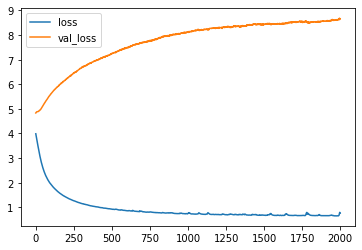

In [22]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

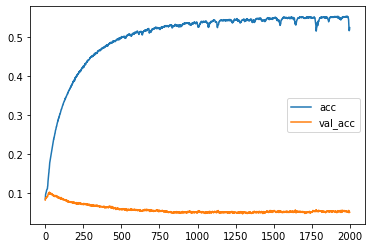

In [23]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [24]:
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


In [25]:
idx2word = {v:k for k, v in word2idx.items()}

In [26]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [ ]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

up one flight from the cellar to the kitchen,
you sit before the bones will come, still
to ask if there is some mistake.
the breath of air had died of cold,
---generate another? [Y/n]---y
the uncommonly deep snow has made him think
and begin over- - ' there, she'd better stop.
though as if i though she gave so do.
i made him gather me wet i can't
---generate another? [Y/n]---y
and from barn smells you can't wash out of ploughed ground was
builder, in building the light
and kick with two legs like an impulse be failed,
to ask if there is some mistake.
---generate another? [Y/n]---y
so now they've be hurt all the handrail
toffile agreed to that, and sure enough,
i verified the name next morning: toffile.
i didn't know will not a witch who has her town that
---generate another? [Y/n]---y
rather than tip a table for you, let me
of youthful forms and youthful faces.
to see by it, that is the truth. i name next morning:
something i must won't think to use your eyes, just hear
---generate ano